In [1]:
import pandas as pd
import json

def parse_json_to_dataframe(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
        
    rows = []
    for entry in data:
        image_info = entry["image"]
        image_pathname = image_info["pathname"]
        image_height = image_info["shape"]["r"]
        image_width = image_info["shape"]["c"]
        
        for obj in entry["objects"]:
            bounding_box = obj["bounding_box"]
            xmin = bounding_box["minimum"]["c"]
            ymin = bounding_box["minimum"]["r"]
            xmax = bounding_box["maximum"]["c"]
            ymax = bounding_box["maximum"]["r"]
            label = obj["category"]
            
            boxes = [xmin, ymin, xmax, ymax]
            
            rows.append([image_pathname, image_height, image_width, boxes, label])
    
    df = pd.DataFrame(rows, columns=['pathname', 'height', 'width', 'boxes', 'label'])
    return df


In [2]:
json_file_path = r".\test.json"
df = parse_json_to_dataframe(json_file_path)
df.head()

,pathname,height,width,boxes,label
0,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1383,1944,"[1744, 576, 1883, 708]",red blood cell
1,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1383,1944,"[1249, 863, 1373, 977]",red blood cell
2,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1383,1944,"[1573, 210, 1711, 335]",red blood cell
3,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1383,1944,"[1124, 1017, 1253, 1142]",red blood cell
4,/images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg,1383,1944,"[1655, 572, 1763, 695]",red blood cell


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5922 entries, 0 to 5921
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pathname  5922 non-null   object
 1   height    5922 non-null   int64 
 2   width     5922 non-null   int64 
 3   boxes     5922 non-null   object
 4   label     5922 non-null   object
dtypes: int64(2), object(3)
memory usage: 231.5+ KB


In [4]:
df['label'].value_counts()

red blood cell    5614
ring               169
trophozoite        111
gametocyte          12
schizont            11
difficult            5
Name: label, dtype: int64

In [7]:
def check_boxes_validity(box: list, h, w):
    assert type(h) == int, f"h is {h}"
    assert type(w) == int, f"w is {w}"
    if isinstance(box, list):
        if (box[0] < box[2]) and (box[1] < box[3]):
            if (box[2] <= w) and (box[3] <= h):
                return True
            else:
                return False
        else:
            return False
    else:
        return False

df.loc[:, 'validity'] = df.apply(lambda row: check_boxes_validity(row[3], row[1], row[2]), axis=1)
len(df[df['validity'] == False])

0

In [8]:
df.drop(columns=['validity'], inplace=True)

In [9]:
def calculate_bbox_area(bbox):
    width = bbox[2] - bbox[0]  # xmax - xmin
    height = bbox[3] - bbox[1]  # ymax - ymin
    area = width * height
    return area

df.loc[:, 'area'] = df['boxes'].apply(calculate_bbox_area)

In [10]:
def to_rbc(label: str):
    if label == 'red blood cell':
        return 'RBC'
    else:
        return label
    
df.loc[:, 'label'] = df['label'].apply(to_rbc)

In [11]:
df['label'].value_counts()

RBC            5614
ring            169
trophozoite     111
gametocyte       12
schizont         11
difficult         5
Name: label, dtype: int64

In [12]:
def calculate_bbox_aspect_ratio(bbox):
    width = bbox[2] - bbox[0] #xmax - xmin
    height = bbox[3] - bbox[1] #ymax - ymin
    return height / width

df.loc[:, 'aspect_ratio'] = df['boxes'].apply(calculate_bbox_aspect_ratio)

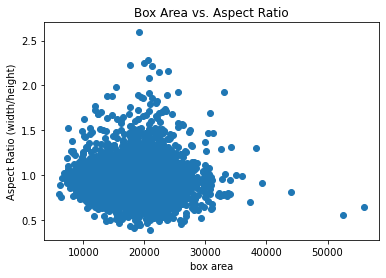

In [13]:
import matplotlib.pyplot as plt

plt.scatter(df['area'], df['aspect_ratio'])

# Set the labels and title
plt.xlabel('box area')
plt.ylabel('Aspect Ratio (width/height)')
plt.title('Box Area vs. Aspect Ratio')

# Display the plot
plt.show()

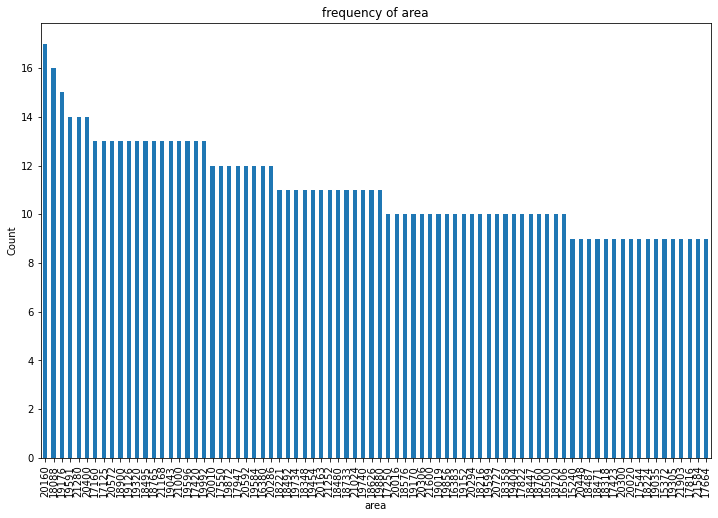

In [14]:
area_counts = df['area'].value_counts()

area_counts = area_counts.head(80)

# Plot the bar plot with figsize and limit
fig, ax = plt.subplots(figsize=(12, 8))
area_counts.plot.bar(ax=ax)

# Set the labels and title
plt.xlabel('area')
plt.ylabel('Count')
plt.title('frequency of area')

# Display the plot
plt.show()

In [15]:
import numpy as np
grouped = df.groupby('pathname').agg({'width': lambda x: x.iloc[0],
                                     'height': lambda x: x.iloc[0],
                                     'label': lambda x: list(x),
                                     'boxes': lambda x: np.stack(x).tolist(),
                                     'area': lambda x: list(x)})
grouped = grouped.reset_index()
grouped.head()

,pathname,width,height,label,boxes,area
0,/images/010961af-b38c-49de-aca0-e3732d73d414.jpg,1944,1383,"[RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, ...","[[534, 437, 663, 565], [1227, 863, 1362, 991],...","[16512, 17280, 14399, 17810, 18078, 20010, 180..."
1,/images/0346611b-ea43-45bd-9f16-c6e8086273d2.jpg,1944,1383,"[RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, ...","[[1061, 1222, 1186, 1339], [1171, 385, 1309, 5...","[14625, 17250, 17780, 17484, 18318, 13688, 174..."
2,/images/03be08c8-2cf3-4de6-8ac6-5f7817a6a643.jpg,1944,1383,"[RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, ...","[[1267, 634, 1398, 758], [1236, 19, 1371, 162]...","[16244, 19305, 17420, 17955, 20160, 22638, 200..."
3,/images/06bbcd42-3ba8-4476-8804-8455f56dd928.jpg,1944,1383,"[RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, ...","[[911, 1157, 1050, 1284], [612, 1181, 752, 131...","[17653, 18200, 19176, 17958, 18560, 19845, 210..."
4,/images/0864c569-2ad7-48ed-b12a-e40aa5b93756.jpg,1944,1383,"[RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, RBC, ...","[[726, 970, 846, 1091], [444, 871, 580, 997], ...","[14520, 17136, 12543, 14157, 14280, 19684, 178..."


In [16]:
heights = grouped.height

print('MEAN     : ' , np.mean(heights))
print('MAX VALUE: ' , np.amax(heights))
print('MIN VALUE: ' , np.amin(heights))
print('PCTL 25% : ' , np.percentile(heights, 25))
print('PCTL 50% : ' , np.percentile(heights, 50))
print('PCTL 75% : ' , np.percentile(heights, 75))

MEAN     :  1383.0
MAX VALUE:  1383
MIN VALUE:  1383
PCTL 25% :  1383.0
PCTL 50% :  1383.0
PCTL 75% :  1383.0


In [17]:
widths = grouped.width

print('MEAN     : ' , np.mean(widths))
print('MAX VALUE: ' , np.amax(widths))
print('MIN VALUE: ' , np.amin(widths))
print('PCTL 25% : ' , np.percentile(widths, 25))
print('PCTL 50% : ' , np.percentile(widths, 50))
print('PCTL 75% : ' , np.percentile(widths, 75))

MEAN     :  1944.0
MAX VALUE:  1944
MIN VALUE:  1944
PCTL 25% :  1944.0
PCTL 50% :  1944.0
PCTL 75% :  1944.0


In [16]:
grouped.to_csv("test.csv", index=False)

In [18]:
df.to_csv("sparse_test.csv", index=False)